In [ ]:
# 패딩
max_words = 5000    
max_len=50         

def tokenize_pad_sequences(text):
    '''
    This function tokenizes the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

print('Before Tokenization & Padding \n', df2['cleantext2'][0])
X, tokenizer = tokenize_pad_sequences(df2['cleantext2'])
print('After Tokenization & Padding \n', X[0])

Before Tokenization & Padding 
 ont long posit v2 entri 0 7179 target 0 7213 stop 0 7106 binanc bitcoin signal buy ontusdt ont 
After Tokenization & Padding 
 [3205   75  224 1468  327   17  176   17  202   17   12    1   81   19
 3205    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [ ]:
class0=[]
for i in range(len(df2)):
    if df2.loc[i,'vader_neg']>0:
        class0+=[-1]
    elif df2.loc[i,'vader_pos']>0:
        class0+=[1]        
    else:
        class0+=[0]    

In [ ]:
df2['class']=class0
df2['class'].value_counts()

 1    4036
 0    3687
-1    2277
Name: class, dtype: int64

In [ ]:
y = pd.get_dummies(df2['class'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
print('Train Set: ', X_train.shape, y_train.shape)
print('Validation Set: ', X_val.shape, y_val.shape)
print('Test Set: ', X_test.shape, y_test.shape)

Train Set:  (6000, 50) (6000, 3)
Validation Set:  (2000, 50) (2000, 3)
Test Set:  (2000, 50) (2000, 3)


In [ ]:
# 가중치 행렬
embedding_matrix = np.zeros((vocab_size, 300))
np.shape(embedding_matrix)

# 학습에 사용되는 단어의 수를 확인
# 패딩 때문에 + 1 

vocab_size = len(tokenizer.index_word) + 1
vocab_size

(20224, 300)

In [ ]:
# 트위터 Sentiment 를 예측하는 모델을 구축 
model0 = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(10000, 128),
  tf.keras.layers.LSTM(128),
  tf.keras.layers.Dense(3, activation='softmax')])

model0.compile(loss='categorical_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])

In [ ]:
model0.fit(X_train, y_train,
          batch_size=128,
          epochs=100,
          validation_split = 0.2)

Epoch 1/100
38/38 [==============================] - 13s 283ms/step - loss: 1.0689 - accuracy: 0.4056 - val_loss: 1.0477 - val_accuracy: 0.4083
Epoch 2/100
38/38 [==============================] - 10s 258ms/step - loss: 0.8751 - accuracy: 0.5800 - val_loss: 0.7851 - val_accuracy: 0.6300
Epoch 3/100
38/38 [==============================] - 11s 279ms/step - loss: 0.5870 - accuracy: 0.7362 - val_loss: 0.6751 - val_accuracy: 0.6983
Epoch 4/100
38/38 [==============================] - 10s 260ms/step - loss: 0.3863 - accuracy: 0.8458 - val_loss: 0.7089 - val_accuracy: 0.7417
Epoch 5/100
38/38 [==============================] - 10s 261ms/step - loss: 0.2736 - accuracy: 0.9115 - val_loss: 0.9388 - val_accuracy: 0.7625
Epoch 6/100
38/38 [==============================] - 10s 261ms/step - loss: 0.2521 - accuracy: 0.9242 - val_loss: 0.6341 - val_accuracy: 0.8117
Epoch 7/100
38/38 [==============================] - 10s 261ms/step - loss: 0.1990 - accuracy: 0.9438 - val_loss: 0.7286 - val_accuracy:

In [ ]:
# Evaluate model on the test set
model0.evaluate(X_test, y_test, verbose=0)

# 각각 loss, accuracy 

[0.7112246751785278, 0.8690000176429749]

# **Sentiment Analysis의 결과를 기반으로 비트의 상하방을 예측하기**

- 비트코인의 상하방 여부는 해당 트윗의 일봉 마감을 기준으로(상방 1, 하방 0) 한다.이에 적합한 EDA가 필요함. 트위터 데이터의 'DATE' 를 EDA 해줄 것 

In [ ]:
df2['date']

0       2021-07-03 10:56:56
1       2022-03-15 09:40:37
2       2022-02-09 18:35:47
3       2021-11-11 17:17:32
4       2021-11-25 16:01:31
               ...         
9995    2021-12-17 13:26:16
9996    2021-08-24 16:55:50
9997    2022-01-22 11:11:39
9998    2022-01-20 02:28:11
9999    2021-10-21 00:16:49
Name: date, Length: 10000, dtype: object

In [ ]:
# 실시간 비트코인 가격을 가져온다 
# 2021년 1월 부터의 데이터로 시작

def get_crypto_price(symbol, exchange, start_date = None):
    api_key = 'YOUR API KEY'
    api_url = f'https://www.alphavantage.co/query?function=DIGITAL_CURRENCY_DAILY&symbol={symbol}&market={exchange}&apikey={api_key}'
    raw_df = requests.get(api_url).json()
    df = pd.DataFrame(raw_df['Time Series (Digital Currency Daily)']).T
    df = df.rename(columns = {'1a. open (USD)': 'open', '2a. high (USD)': 'high', '3a. low (USD)': 'low', '4a. close (USD)': 'close', '5. volume': 'volume'})
    for i in df.columns:
        df[i] = df[i].astype(float)
    df.index = pd.to_datetime(df.index)
    df = df.iloc[::-1].drop(['1b. open (USD)', '2b. high (USD)', '3b. low (USD)', '4b. close (USD)', '6. market cap (USD)'], axis = 1)
    if start_date:
        df = df[df.index >= start_date]
    return df

btc_0 = get_crypto_price(symbol = 'BTC', exchange = 'USD', start_date = '2021-02-05')
btc_0

,open,high,low,close,volume
2021-02-05,36936.65,38310.12,36570.00,38290.24,66681.334275
2021-02-06,38289.32,40955.51,38215.94,39186.94,98757.311183
2021-02-07,39181.01,39700.00,37351.00,38795.69,84363.679763
2021-02-08,38795.69,46794.45,37988.89,46374.87,138597.536914
2021-02-09,46374.86,48142.19,44961.09,46420.42,115499.861712
...,...,...,...,...,...
2022-04-24,39441.61,39940.00,38929.62,39450.13,26703.611860
2022-04-25,39450.12,40616.00,38200.00,40426.08,63037.127840
2022-04-26,40426.08,40797.31,37702.26,38112.65,66650.258000
2022-04-27,38112.64,39474.72,37881.31,39235.72,57083.122720


In [ ]:
# 날짜 -> 인덱스로 빼기
btc_0 = btc_0.reset_index()

In [ ]:
btc_0['index'] = pd.to_datetime(btc_0['index'], unit='s')
btc_0.index = btc_0['index']
btc_0_grouped = btc_0.resample('D')['close'].mean()

In [ ]:
tweets = df2.copy()
tweets['date'] = pd.to_datetime(tweets['date'],utc=True)
tweets.date = tweets.date.dt.tz_localize(None)
tweets.index = tweets['date']
tweets_grouped = tweets.resample('1h').sum()

In [ ]:
tweets_grouped

,user_followers,user_friends,user_favourites,user_verified,is_retweet,vader_neg,vader_neu,vader_pos,vader_comp,class
date,,,,,,,,,,
2021-02-05 12:00:00,957.0,734.0,2780.0,0,0,0.000,0.798,0.202,0.5106,1
2021-02-05 13:00:00,0.0,0.0,0.0,0,0,0.000,0.000,0.000,0.0000,0
2021-02-05 14:00:00,4154.0,76.0,46.0,0,0,0.000,1.000,0.000,0.0000,0
2021-02-05 15:00:00,0.0,0.0,0.0,0,0,0.000,0.000,0.000,0.0000,0
2021-02-05 16:00:00,131.0,5.0,4.0,0,0,0.000,1.000,0.000,0.0000,0
...,...,...,...,...,...,...,...,...,...,...
2022-04-22 19:00:00,57442.0,4064.0,83132.0,0,0,0.000,8.404,0.596,2.2009,5
2022-04-22 20:00:00,5955.0,4313.0,41186.0,0,0,0.367,7.596,1.037,3.3339,3
2022-04-22 21:00:00,373.0,283.0,102.0,0,0,0.000,2.723,0.277,0.8718,2


In [ ]:
beginning = max(tweets_grouped.index.min().replace(tzinfo=None), btc_0_grouped.index.min())
end = min(tweets_grouped.index.max().replace(tzinfo=None), btc_0_grouped.index.max())
tweets_grouped = tweets_grouped[beginning:end]
btc_0_grouped = btc_0_grouped[beginning:end]

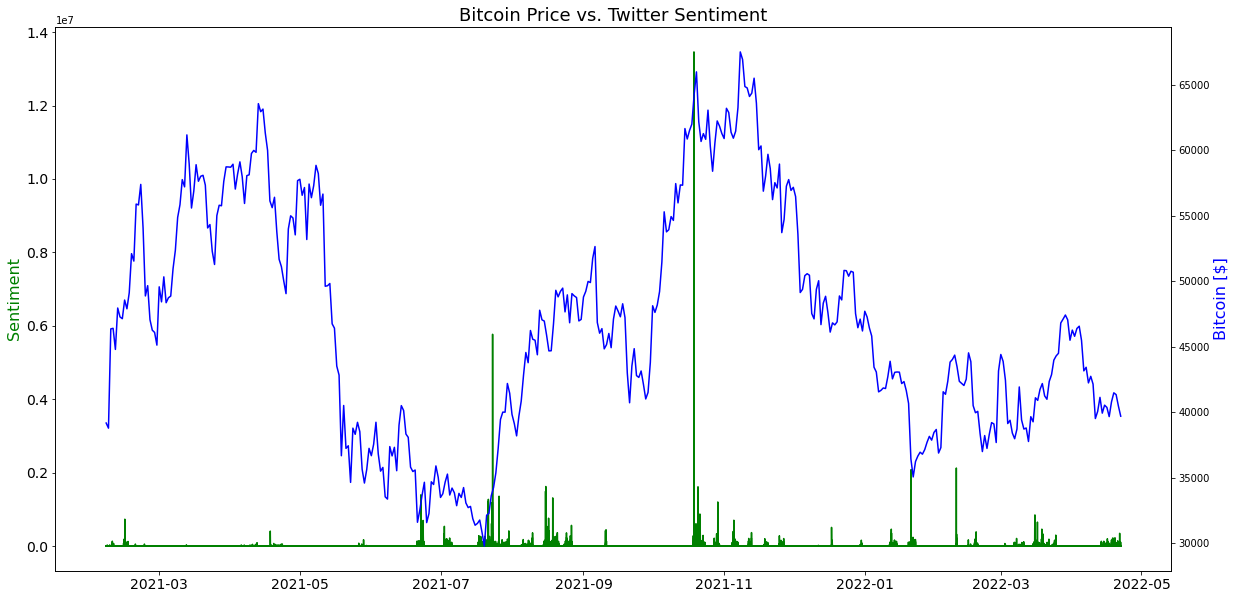

In [ ]:
# 비트코인 가격과 Sentiment 를 비교하는 그래프 

fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title("Bitcoin Price vs. Twitter Sentiment", fontsize=18) # 제목 수정하기 
ax1.tick_params(labelsize=14)
ax2 = ax1.twinx()
ax1.plot_date(tweets_grouped.index, tweets_grouped, 'g-')
ax2.plot_date(btc_0_grouped.index, btc_0_grouped, 'b-')

ax1.set_ylabel("Sentiment", color='g', fontsize=16)
ax2.set_ylabel("Bitcoin [$]", color='b', fontsize=16)
plt.show()

In [ ]:
# object 에서 datetime64[ns]로 자료형 변환 
df2['date'] = pd.to_datetime(df2['date'])


In [ ]:
#자료형 변환 후 분,시간,초 드랍하기 -> DateMod 칼럼에 저장 
df2['DateMod'] = df2['date'].dt.floor('d')
df2 

In [ ]:
df3 = df2

In [ ]:
pd.merge(df3, btc_0, on="DateMod")

In [ ]:
df2['vader_comp']

0       0.2960
1       0.4939
2       0.5719
3       0.0000
4      -0.5423
         ...  
9995    0.2263
9996    0.0000
9997    0.0000
9998    0.0000
9999    0.6908
Name: vader_comp, Length: 10000, dtype: float64

In [ ]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title("비트코인 가격 vs Twitter Sentiment", fontsize=18)
ax1.tick_params(labelsize=14)
ax2 = ax1.twinx()
ax1.plot_date(tweets_grouped.index, tweets_grouped, 'g-')
ax2.plot_date(crypto_usd_grouped.index, crypto_usd_grouped, 'b-')

ax1.set_ylabel("Sentiment", color='g', fontsize=16)
ax2.set_ylabel("Bitcoin [$]", color='b', fontsize=16)
plt.show()

In [ ]:
df2.to_csv('/content/drive/MyDrive/Colab Notebooks/df2shuffle_date.csv')


In [ ]:
df3 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/df2shuffle_date.csv") #데이터셋 불러오기 

In [ ]:
# 필요없는 칼럼 제거 
df2 = df2.loc[:, ~df2.columns.str.contains('^Unnamed')]
# df1

In [ ]:
df2

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,...,source,is_retweet,cleantext,vader_neg,vader_neu,vader_pos,vader_comp,cleantext2,class,DateMod
0,Hoba Bot,NaN,Fearless like a Honey Badger... Bears or Bulls...,2012-12-30 21:55:51,13144.0,7.0,143.0,False,2021-07-03 10:56:56,🚀🚀🚀 $ONT Long Position(v2) 🚀🚀🚀\n\nEntry: 0.717...,...,HoBaBot,False,"['ont', 'long', 'posit', 'v2', 'entri', '0', '...",0.128,0.872,0.000,-0.2960,ont long posit v2 entri 0 7179 target 0 7213 s...,-1,2021-07-03
1,𝔡𝔢𝔣𝔦𝔱𝔯𝔞𝔩𝔦𝔷𝔢𝔡•pǝzıןɐɹʇıɟǝp,NaN,Defitralized © • DC of @_dcdao ...,2015-09-01 23:34:35,132.0,2387.0,8030.0,False,2022-03-15 09:40:37,10% discount\nhttps://t.co/1360Y2IRC7\n\n #BTC...,...,Twitter for Android,False,"['10', 'discount', 'http', 'co', '1360y2irc7',...",0.000,1.000,0.000,0.0000,10 discount http co 1360y2irc7 btc inliqwetrus...,0,2022-03-15
2,GORE I.A.D,Deutschland,telegram https://t.co/ui9meh3B41\nMOD https://...,2021-12-03 13:05:19,44.0,397.0,5689.0,False,2022-02-09 18:35:47,@crypto_bearr Join us In #Aether Before the la...,...,Twitter for Android,False,"['crypto', 'bearr', 'join', 'us', 'aether', 'l...",0.000,0.936,0.064,0.2960,crypto bearr join us aether launch satellit or...,1,2022-02-09
3,satsleft.info,The Bitcoin Timechain,Reporting on the remaining #Bitcoin supply to ...,2021-10-14 21:31:42,92.0,251.0,12.0,False,2021-11-11 17:17:32,👋 A new block was found on the #Bitcoin networ...,...,satsleft,False,"['new', 'block', 'found', 'bitcoin', 'network'...",0.293,0.707,0.000,-0.7003,new block found bitcoin network block height 7...,-1,2021-11-11
4,Dweep,NaN,"Vocalist, Musician, Author\n-CRYPTO maniac-",2017-08-17 15:01:18,8.0,49.0,283.0,False,2021-11-25 16:01:31,@CryptoWhale Its just whale games. Plan B made...,...,Twitter for Android,False,"['cryptowhal', 'whale', 'game', 'plan', 'b', '...",0.000,0.791,0.209,0.7003,cryptowhal whale game plan b made whole market...,1,2021-11-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,Bitcoin tips,NaN,NaN,2017-09-21 09:19:00,58.0,223.0,85.0,False,2021-12-17 13:26:16,@saylor It's almost ready to fly #Bitcoin,...,Twitter for Android,False,"['saylor', 'almost', 'readi', 'fli', 'bitcoin']",0.000,1.000,0.000,0.0000,saylor almost readi fli bitcoin,0,2021-12-17
9996,Somnath Sahoo 💎,NaN,@Cardano @CotiNetwork \n@Ripple,2017-01-15 02:33:18,135.0,319.0,13924.0,False,2021-08-24 16:55:50,#Bitcoin New Price Predication 4th September 21,...,Twitter for Android,False,"['bitcoin', 'new', 'price', 'predic', '4th', '...",0.000,1.000,0.000,0.0000,bitcoin new price predic 4th septemb 21,0,2021-08-24
9997,Zerinei Mooly,"Saint Andrews, Scotland",+100 I Per Day\n#pinetwork #BTC\n#polydoge,2013-09-30 12:11:16,186.0,591.0,654.0,False,2022-01-22 11:11:39,whoever buys bitcoin means he wins the future ...,...,Twitter for Android,False,"['whoever', 'buy', 'bitcoin', 'mean', 'win', '...",0.000,0.774,0.226,0.5859,whoever buy bitcoin mean win futur market coin...,1,2022-01-22
9998,GHC雄起,NaN,NaN,2022-01-17 03:06:46,1.0,4.0,212.0,False,2022-01-20 02:28:11,@VT6688 @GenxAnalytics @GalaxyHeroesGHC @rarib...,...,Twitter for Android,False,"['vt6688', 'genxanalyt', 'galaxyheroesghc', 'r...",0.000,0.893,0.107,0.5574,vt6688 genxanalyt galaxyheroesghc raribl theuf...,1,2022-01-20


In [ ]:
df2= df2.groupby([df2['DateMod'].dt.date]).mean()
df2

,user_followers,user_friends,user_favourites,user_verified,is_retweet,vader_neg,vader_neu,vader_pos,vader_comp,class
DateMod,,,,,,,,,,
2021-02-05,1994.285714,501.000000,2004.428571,0.000000,0.0,0.014857,0.901286,0.083857,0.174700,0.285714
2021-02-06,3119.500000,2596.900000,1274.400000,0.000000,0.0,0.000000,0.863400,0.136600,0.323380,0.600000
2021-02-07,4585.888889,3602.111111,2935.555556,0.000000,0.0,0.000000,0.958333,0.041667,0.079822,0.111111
2021-02-08,6374.850000,486.700000,8881.300000,0.000000,0.0,0.004700,0.908050,0.087250,0.165640,0.300000
2021-02-09,3115.333333,146.777778,9799.333333,0.000000,0.0,0.035667,0.896222,0.068111,0.029989,0.111111
...,...,...,...,...,...,...,...,...,...,...
2022-04-18,4479.049689,873.316770,8823.602484,0.006211,0.0,0.027832,0.891571,0.080596,0.143122,0.111801
2022-04-19,6439.160221,777.972376,3621.591160,0.005525,0.0,0.018762,0.874597,0.106641,0.246082,0.320442
2022-04-20,4132.268293,1366.707317,8383.463415,0.000000,0.0,0.052463,0.868268,0.079244,0.059080,-0.121951


In [ ]:
# 'price_updown' 컬럼 : 가격이 상승으로 마감하면 1, 하락으로 마감하면 0 으로 변환 
df2

,DateMod,user_followers,user_friends,user_favourites,user_verified,is_retweet,vader_neg,vader_neu,vader_pos,vader_comp,class,price_updown
0,2021.2.5,1994.285714,501.000000,2004.428571,0.000000,0,0.014857,0.901286,0.083857,0.174700,0.285714,1
1,2021.2.6,3119.500000,2596.900000,1274.400000,0.000000,0,0.000000,0.863400,0.136600,0.323380,0.600000,1
2,2021.2.7,4585.888889,3602.111111,2935.555556,0.000000,0,0.000000,0.958333,0.041667,0.079822,0.111111,0
3,2021.2.8,6374.850000,486.700000,8881.300000,0.000000,0,0.004700,0.908050,0.087250,0.165640,0.300000,1
4,2021.2.9,3115.333333,146.777778,9799.333333,0.000000,0,0.035667,0.896222,0.068111,0.029989,0.111111,1
...,...,...,...,...,...,...,...,...,...,...,...,...
135,2022.4.18,4479.049689,873.316770,8823.602484,0.006211,0,0.027832,0.891571,0.080596,0.143122,0.111801,1
136,2022.4.19,6439.160221,777.972376,3621.591160,0.005525,0,0.018762,0.874597,0.106641,0.246082,0.320442,1
137,2022.4.20,4132.268293,1366.707317,8383.463415,0.000000,0,0.052463,0.868268,0.079244,0.059080,-0.121951,0
138,2022.4.21,6462.631068,566.242718,4453.155340,0.019417,0,0.036942,0.874680,0.088359,0.132678,0.067961,0


In [ ]:
# object 에서 datetime64[ns]로 자료형 변환 
df2['DateMod'] = pd.to_datetime(df2['DateMod'])

#자료형 변환 후 분,시간,초 드랍하기 -> DateMod 칼럼에 저장 
df2['DateMod'] = df2['DateMod'].dt.floor('d')
df2 

,DateMod,user_followers,user_friends,user_favourites,user_verified,is_retweet,vader_neg,vader_neu,vader_pos,vader_comp,class,price_updown
0,2021-02-05,1994.285714,501.000000,2004.428571,0.000000,0,0.014857,0.901286,0.083857,0.174700,0.285714,1
1,2021-02-06,3119.500000,2596.900000,1274.400000,0.000000,0,0.000000,0.863400,0.136600,0.323380,0.600000,1
2,2021-02-07,4585.888889,3602.111111,2935.555556,0.000000,0,0.000000,0.958333,0.041667,0.079822,0.111111,0
3,2021-02-08,6374.850000,486.700000,8881.300000,0.000000,0,0.004700,0.908050,0.087250,0.165640,0.300000,1
4,2021-02-09,3115.333333,146.777778,9799.333333,0.000000,0,0.035667,0.896222,0.068111,0.029989,0.111111,1
...,...,...,...,...,...,...,...,...,...,...,...,...
135,2022-04-18,4479.049689,873.316770,8823.602484,0.006211,0,0.027832,0.891571,0.080596,0.143122,0.111801,1
136,2022-04-19,6439.160221,777.972376,3621.591160,0.005525,0,0.018762,0.874597,0.106641,0.246082,0.320442,1
137,2022-04-20,4132.268293,1366.707317,8383.463415,0.000000,0,0.052463,0.868268,0.079244,0.059080,-0.121951,0
138,2022-04-21,6462.631068,566.242718,4453.155340,0.019417,0,0.036942,0.874680,0.088359,0.132678,0.067961,0


In [ ]:
# 훈련/테스트 데이터셋으로 나누기 
from sklearn.model_selection import train_test_split 
train, test = train_test_split(df2, train_size = 0.80,
                               shuffle=True, random_state=121)

In [ ]:
# Dividing the Dataset 
feature = ['vader_neg', 'vader_neu', 'vader_pos', 'vader_comp','class']
target = ['price_updown']

X_train = train[feature]
Y_train = train[target]
X_test = test[feature]
Y_test = test[target]

X_train.shape, X_test.shape

((112, 5), (28, 5))

In [ ]:
model1 = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(10000, 128),
  tf.keras.layers.LSTM(128),
  tf.keras.layers.Dense(1, activation='sigmoid')])

model1.compile(loss='binary_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])

In [ ]:
model1.fit(X_train, Y_train,
          batch_size=128,
          epochs=100,
          validation_split = 0.2)

Epoch 1/100
1/1 [==============================] - 4s 4s/step - loss: 0.6931 - accuracy: 0.5056 - val_loss: 0.6935 - val_accuracy: 0.4783
Epoch 2/100
1/1 [==============================] - 0s 81ms/step - loss: 0.6932 - accuracy: 0.4944 - val_loss: 0.6929 - val_accuracy: 0.5217
Epoch 3/100
1/1 [==============================] - 0s 80ms/step - loss: 0.6930 - accuracy: 0.5056 - val_loss: 0.6926 - val_accuracy: 0.5217
Epoch 4/100
1/1 [==============================] - 0s 84ms/step - loss: 0.6930 - accuracy: 0.5056 - val_loss: 0.6925 - val_accuracy: 0.5217
Epoch 5/100
1/1 [==============================] - 0s 77ms/step - loss: 0.6930 - accuracy: 0.5056 - val_loss: 0.6926 - val_accuracy: 0.5217
Epoch 6/100
1/1 [==============================] - 0s 74ms/step - loss: 0.6929 - accuracy: 0.5056 - val_loss: 0.6929 - val_accuracy: 0.5217
Epoch 7/100
1/1 [==============================] - 0s 78ms/step - loss: 0.6928 - accuracy: 0.5056 - val_loss: 0.6931 - val_accuracy: 0.5217
Epoch 8/100
1/1 [=====

In [ ]:
# Evaluate model on the test set
model1.evaluate(X_test, Y_test, verbose=0)

# Sentiment Analysis 로 가격을 예측하게 되면 0.5의 정확도를 보임

[0.6931901574134827, 0.5]